# The Agent-Environment Interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment. 

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward (i.e. the undiscounted return) obtained by the two agents for each episode. This kind of graph is called a **learning curve**, and it gives us an idea of how our agent's performance changes during training.


## The agent-environment interface

<img src="img/agent-environment.png" style="width: 500px;" align="left"/> 

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$. 


## The environment: Navigation in a gridworld

<img src="img/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. If the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at a randomly selected initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-Learning
For your reference, the pseudocode for the Q-Learning algorithm is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).
<img src="img/q.png" style="width: 720px;"/>


## Example of a learning curve

<img src="img/lc_example.png" style="width: 550px;" align="left"/>

<br><br><br><br>

This is a sample learning curve and shows the reward obtained by a Q-learning agent across 500 episodes. Do not try to replicate this exact curve! It was computed using a different environment than the one described here.

In [1]:
# environment
import numpy as np

class Gridworld:
    def __init__(self):
        self.num_rows = 5
        self.num_cols = 5
        self.num_cells = self.num_cols * self.num_rows
        self.random_move_probability = 0.2
        
        # Choose starting position of the agent randomly among the first 5 cells
        self.agent_position = np.random.randint(0, 5)
        
        # Choose position of the gold and bomb
        self.bomb_positions = np.array([18])
        self.gold_positions = np.array([23])
        self.terminal_states = np.array([self.bomb_positions, self.gold_positions])
       
        # Specify rewards
        self.rewards = np.zeros(self.num_cells)
        self.rewards[self.bomb_positions] = -10
        self.rewards[self.gold_positions] = 10
        
        # Specify available actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.num_actions = len(self.actions)
        
    def get_available_actions(self):
        return self.actions
    
    def get_start_location(self):
        return self.agent_position
    
    def make_step(self, action_index): 
        # Randomly sample action_index if world is stochastic
        if np.random.uniform(0, 1) < self.random_move_probability:
            action_indices = np.arange(self.num_actions, dtype=int)
            action_indices = np.delete(action_indices, action_index)
            action_index = np.random.choice(action_indices, 1)[0]

        action = self.actions[action_index]

        # Determine new position and check whether the agent hits a wall.
        old_position = self.agent_position
        new_position = self.agent_position
        if action == "DOWN":
            candidate_position = old_position + self.num_cols
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "RIGHT":
            candidate_position = old_position + 1
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "UP":
            candidate_position = old_position - self.num_cols
            if candidate_position >= 0:
                new_position = candidate_position
        elif action == "LEFT":  # "LEFT"
            candidate_position = old_position - 1
            if candidate_position >= 0:
                new_position = candidate_position
        else:
            raise ValueError('Action was mis-specified!')

        # Update the environment state
        self.agent_position = new_position
        
        # Calculate reward
        reward = self.rewards[self.agent_position]
        reward -= 1
        return reward, new_position
    
    def reset(self):
        self.agent_position = np.random.randint(0, 5)
        return self.agent_position
        

In [2]:
class RandomAgent():
    def choose_action(self, available_actions):
        number_of_actions = len(available_actions)
        random_action_index = np.random.randint(0, number_of_actions)
        return random_action_index

In [3]:
class QLearningAgent():
    def __init__(self, start_location):
        # table in format: Position, Action, Q-Value
        #self.q_table = np.zeros((1,2))
        self.q_table = {}
        self.position = start_location
    
    def choose_action(self, available_actions):
        # check if current action/state in q-table
        for i in range(4):
            if  not (self.position, i) in self.q_table:
                self.q_table[self.position, i] = 0
        
        # decide if random or greedy
        # random action 5% time, greedy 95%
        if np.random.uniform(0, 1) > 0.95:
            print("Random action chosen.")
            # random action
            number_of_actions = len(available_actions)
            return np.random.randint(0, number_of_actions)
        else:
            # greedy action
            print("Greedy action chosen.")
            best_action = 0
            for i in range(4):
                if self.q_table[self.position, i] > self.q_table[self.position, best_action]:
                    best_action = i
            return best_action
        
    def update_table(self, reward, new_position, action):
        # find q value and update table with it
        learning_rate = 0.1
        # find new estimate
        newEstimate = 0
        for i in range(4):
            if  not (new_position, i) in self.q_table:
                self.q_table[new_position, i] = 0
            else:
                if self.q_table[new_position, i] > newEstimate:
                    newEstimate = self.q_table[new_position, i]
        q_value = round(((1-learning_rate) * self.q_table[self.position, action]) + learning_rate*(reward + newEstimate), 2)
        self.q_table[self.position, action] = q_value
        # update position to new position
        self.position = new_position

    def print_table(self):
        print(self.q_table)
        
    def update_position(self, new_position):
        self.position = new_position

In [4]:
env = Gridworld()
agent = RandomAgent()
Qagent = QLearningAgent(env.get_start_location())

In [5]:
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = Qagent.choose_action(available_actions)
print("Chosen action =", chosen_action)
reward, position = env.make_step(chosen_action)
Qagent.update_table(reward, position, chosen_action)

Available_actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
Greedy action chosen.
Chosen action = 0


In [6]:
episodeNumber = 500
yValues = []
xValues = range(episodeNumber)
for i in range(episodeNumber):
    print("Episode: ", i)
    totalReward = 0
    reward = 0
    while reward != 9 and reward != -11:
        print("Current position of the agent =", env.agent_position)
        available_actions = env.get_available_actions()
        chosen_action = Qagent.choose_action(available_actions)
        print("Chosen action =", available_actions[chosen_action])
        reward, position = env.make_step(chosen_action)
        print("Reward obtained =", reward)
        Qagent.update_table(reward, position, chosen_action)
        print("Current position of the agent =", env.agent_position)
        totalReward+= reward
    starting_location = env.reset()
    Qagent.update_position(starting_location)
    yValues.append(totalReward)

Episode:  0
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.

Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of t

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 14
Current position of the agent = 14
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position

Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 20
Current position of the agent = 20
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 20
Current position of the agent = 20
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current positi

Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Ch

Reward obtained = 9.0
Current position of the agent = 23
Episode:  14
Current position of the agent = 3
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent

Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 3
Curren

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 2
Current

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 5
Current

Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -11.0
Current position of the agent = 18
Episode:  25
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of th

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen act

Current position of the agent = 7
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen actio

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Random action chosen.
Chosen action = DOWN

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of

Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 14
Current position of the agent = 14
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 15
Current position of the agent = 15
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 16
Current

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent 

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3


Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy a

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
R

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of

Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy a

Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 13
Current position of the agent = 13
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 14
Current position of the agent = 14
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 14
Current position of the agent = 14
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 15
Current position of the agent = 15
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action c

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action =

Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy a

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
R

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent =

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent =

Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3


Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Random a

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
R

Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current posi

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 

Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy a

Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
R

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of

Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2


Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greed

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
R

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2


Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy a

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Random action chosen.
Chosen action = DOWN

Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = U

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of

Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of

Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
R

Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 13
Current position of the agent = 13
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 14
Current position of the agent = 14
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 19
Current p

Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of

Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Random a

Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  69
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position 

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of

Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current po

Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
R

Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
R

Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 9
Current position of the agent = 9
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 9
Current positi

Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Random action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy a

Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current po

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = U

Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  82
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position o

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Random action chosen.
Chosen action = DOWN

Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  87
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of 

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of

Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of

Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  97
Current position of the agent = 2
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the

Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  101
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the 

Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  108
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of

Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP

Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of

Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 10
Current position of the agent = 10
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the a

Reward obtained = -1.0
Current position of the agent = 15
Current position of the agent = 15
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  136
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of 

Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  142
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position

Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  153
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
E

Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  163
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action

Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12


Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  178
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current positio

Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 20
Current position of the agent = 20
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 20
Current position of the agent = 20
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  198
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4

Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the 

Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  225
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Gr

Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current positio

Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Random action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  254
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Curr

Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  263
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward ob

Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 20
Current position of the agent = 20
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  277
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent =

Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  293
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy

Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  313
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current positi

Current position of the agent = 11
Current position of the agent = 11
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  

Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  344
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current positio

Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Random action chosen.
Chosen action = UP
Reward obtained = -1.0
Cur

Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Random action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  377
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtain

Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Curre

Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  404
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position

Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Random action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
G

Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Random action chosen.
Chosen action = RIGHT
Reward obtained = -11.0
Current position of the agent = 18
Episode:  438
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 5
Current position of the agent = 5
Greedy action chosen.
Chosen action = UP
Reward obtained 

Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 8
Current position of the agent = 8
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 12
Current position of the agent = 12
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 13
Current position of the agent = 13
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -11.0
Current position of the agent = 18
Episode:  451
Current position of the agent = 0
Greedy act

Reward obtained = -1.0
Current position of the agent = 17
Current position of the agent = 17
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  465
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 4
Current position of the agent = 4
Greedy action chosen.
Chosen action = UP
Reward obtained = -1.0
Current position of the agent = 3
Current position of the agent = 3
Greedy action chosen.
Chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = 2
Current position of the agent = 2
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the ag

Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  483
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 0
Current position of the agent = 0
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 1
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 7
Current position of the agent = 7
Greedy action chosen.
Chosen action = DO

Current position of the agent = 1
Random action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 11
Current position of the agent = 11
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 16
Current position of the agent = 16
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 21
Current position of the agent = 21
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = -1.0
Current position of the agent = 22
Current position of the agent = 22
Greedy action chosen.
Chosen action = RIGHT
Reward obtained = 9.0
Current position of the agent = 23
Episode:  499
Current position of the agent = 1
Greedy action chosen.
Chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = 6
Current position of the agent = 6
Gree

In [7]:
Qagent.print_table()

{(0, 0): -0.96, (0, 1): -0.18, (0, 2): -0.96, (0, 3): -0.96, (1, 0): -0.65, (1, 1): -0.66, (1, 2): 1.34, (1, 3): -0.96, (2, 0): -0.56, (2, 1): -0.6, (2, 2): 0.82, (2, 3): -0.82, (3, 0): -0.96, (3, 1): -0.96, (3, 2): -0.86, (3, 3): -0.08, (4, 0): -0.96, (4, 1): -0.96, (4, 2): -0.96, (4, 3): -0.96, (5, 0): -0.88, (5, 1): -0.96, (5, 2): -0.96, (5, 3): -0.96, (9, 0): -0.46, (9, 1): -0.96, (9, 2): -0.81, (9, 3): -0.96, (14, 0): -0.79, (14, 1): -0.65, (14, 2): 1.82, (14, 3): -0.74, (10, 0): -0.91, (10, 1): 2.13, (10, 2): -0.9, (10, 3): -0.92, (6, 0): -0.78, (6, 1): -0.5, (6, 2): 2.53, (6, 3): -0.89, (7, 0): -0.96, (7, 1): -0.96, (7, 2): 1.69, (7, 3): -0.52, (8, 0): -0.74, (8, 1): -0.96, (8, 2): -0.96, (8, 3): -0.96, (15, 0): -0.65, (15, 1): 3.38, (15, 2): -0.61, (15, 3): -0.65, (11, 0): -0.46, (11, 1): 0.02, (11, 2): 4.15, (11, 3): 0.08, (13, 0): -1.77, (13, 1): -1.97, (13, 2): -2.98, (13, 3): -2.67, (12, 0): -0.71, (12, 1): -0.53, (12, 2): 3.65, (12, 3): 0.8, (16, 0): 0.76, (16, 1): 0.9, (1

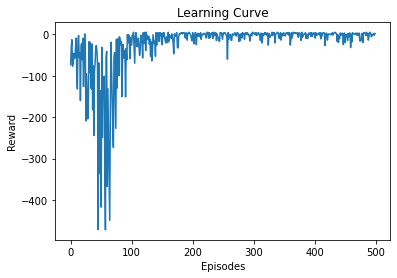

In [8]:
import matplotlib.pyplot as plt
plt.plot(xValues, yValues)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title("Learning Curve")
plt.show()
